# Hannah Zhao - Week 2 DenseNet Model with MIL
## MIL (Multiple Instance Learning) stops you from punishing for “normal‐looking” patches in High-grade cases by moving supervision up to the case level
### Goal: to test the backbone of the MIL model, which is densenet and see if it could learn the patterns well, training a patch classifier model
#### overall results:  not the best, realizing I need to do more inspection on just the densenet and core patch pattern learning model
#### next step: 

In [1]:
# Standard library imports
import os
import re
import random
import shutil
from datetime import datetime
from collections import OrderedDict

# Data handling and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch and TorchVision libraries for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.models as models
from torchvision import transforms, datasets
from PIL import Image

# Scikit-Learn for evaluation metrics and data splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Imbalanced-learn for oversampling to address class imbalance
from imblearn.over_sampling import RandomOverSampler

from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image
from PIL import Image
from PIL import UnidentifiedImageError
from tqdm import tqdm


In [2]:
# Define local file paths

# Define your Desktop folder based on your OS; this uses the user's home directory.
desktop = os.path.join(os.path.expanduser("~"), "Desktop")

# Path to the filtered patches folder on your Desktop
filtered_patches_dir = os.path.join(desktop, "uni", "STAT 390", "Hannah Zhao", "CMIL_SP2025_Patches_Apr16")

# Path to the CSV file inside Desktop/uni/STAT 390/Hannah Zhao
csv_file_path = os.path.join(desktop, "uni", "STAT 390", "Hannah Zhao", "case_grade_match.csv")

# Directory to store model checkpoints
checkpoint_dir = os.path.join(desktop, "uni", "STAT 390", "Hannah Zhao", "Checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)  # Create the directory if it doesn't exist

# load labels 
labels = pd.read_csv(csv_file_path)

In [3]:
# === Helper: group patches
def group_patches(patch_dir):
    case_patches = {}
    for filename in os.listdir(patch_dir):
        match = re.search(r"case_(\d+)", filename)
        if match:
            case_num = int(match.group(1))
            if case_num not in case_patches:
                case_patches[case_num] = []
            case_patches[case_num].append(os.path.join(patch_dir, filename))
    return case_patches

patches = group_patches(filtered_patches_dir)

# Validation / Test transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Training transform (augmented)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [4]:
# Prepare case split
case_nums = list(patches.keys())
dataset = labels.loc[[(x-1) for x in case_nums]]  # Adjust indexing
valid_classes = [1.0, 3.0, 4.0]
filtered_dataset = dataset[dataset['Class'].isin(valid_classes)]

X = filtered_dataset.Case.reset_index(drop=True)
y = filtered_dataset.Class.reset_index(drop=True)


benign_cases = [2, 21, 22, 25, 34, 45, 53, 77, 78, 79, 85, 90]
highgrade_cases = [1, 3, 9, 12, 38, 49, 55, 60, 62, 70, 89, 92, 98, 99]

# Split manually or use random
random.seed(42)
random.shuffle(benign_cases)
random.shuffle(highgrade_cases)

# Choose 3 benign + 3 high-grade for training
train_cases = benign_cases[:3] + highgrade_cases[:3]

# Next 2 of each for validation
val_cases = benign_cases[3:5] + highgrade_cases[3:5]

# The rest for testing
test_cases = benign_cases[5:] + highgrade_cases[5:]

# # === No train_test_split ===
# train_cases = [77, 34, 89, 9]  # 1 benign + 1 high-grade, 84 -- high grade, 86 -- benign
# val_cases = [78, 1]        # 1 benign, 2, 92
# test_cases = [3, 79]        # 1 high-grade

train_patches = {c: patches[c] for c in train_cases if c in patches}
val_patches   = {c: patches[c] for c in val_cases if c in patches}
test_patches  = {c: patches[c] for c in test_cases if c in patches}

# Optional: filter to just H&E stain
def filter_by_stain(d, keyword):
    out = {}
    for c, paths in d.items():
        f = [p for p in paths if keyword.lower() in os.path.basename(p).lower()]
        if f:
            out[c] = f
    return out

stain = "h&e"
train_patches = filter_by_stain(train_patches, stain)
val_patches = filter_by_stain(val_patches, stain)
test_patches = filter_by_stain(test_patches, stain)

In [23]:
print("Original train_cases:", train_cases)
print("Train cases with patches:", list(train_patches.keys()))
print("Missing from train_cases:", [c for c in train_cases if c not in train_patches])


Original train_cases: [77, 45, 22, 9, 49, 60]
Train cases with patches: [77, 9]
Missing from train_cases: [45, 22, 49, 60]


In [27]:
class MILDataset(Dataset):
    def __init__(self, case_patches, labels_df, transform=None, emergency_cap=800):
        self.transform = transform
        self.emergency_cap = emergency_cap  # only cap if massive
        self.bags, self.labels = [], []
        for case, paths in case_patches.items():
            raw = labels_df.loc[labels_df['Case'] == case, 'Class'].item()
            bag_lbl = 0 if raw == 1 else 1
            self.bags.append(paths)
            self.labels.append(bag_lbl)

    def __len__(self): return len(self.bags)

    def __getitem__(self, idx):
        paths = self.bags[idx]
        imgs = []
        for p in paths:
            try:
                img = Image.open(p).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                imgs.append(img)
            except:
                continue

        if len(imgs) == 0:
            raise ValueError(f"No good patches in case {paths}")

        # Only sample if emergency_cap is set
        if self.emergency_cap is not None and len(imgs) > self.emergency_cap:
            imgs = random.sample(imgs, self.emergency_cap)

        return torch.stack(imgs), torch.tensor(self.labels[idx], dtype=torch.long)


class PatchLevelDataset(Dataset):
    def __init__(self, case_patches, labels_df, transform=None, balance=True):
        self.data = []
        self.transform = transform
        self.label_map = {1.0: 0, 3.0: 1, 4.0: 1}
        for case_id, patch_paths in case_patches.items():
            raw_label = labels_df.loc[labels_df['Case'] == case_id, 'Class'].item()
            label = self.label_map[raw_label]
            for patch_path in patch_paths:
                self.data.append((patch_path, label))
        if balance:
            from collections import Counter
            counts = Counter([label for _, label in self.data])
            min_count = min(counts.values())
            balanced = {0: [], 1: []}
            for path, label in self.data:
                if len(balanced[label]) < min_count:
                    balanced[label].append((path, label))
            self.data = balanced[0] + balanced[1]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path, label = self.data[idx]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


class AttentionPool(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x, return_weights=False):
        weights = self.attention(x)     # (B, M, 1)
        weights = torch.softmax(weights, dim=1)
        weighted_x = (weights * x).sum(dim=1)  # (B, D)

        if return_weights:
            return weighted_x, weights.squeeze(-1)  # (B, D), (B, M)
        return weighted_x

class PatchClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        self.features = base.features
        self.pool = nn.AdaptiveAvgPool2d((2, 2))
        self.classifier = nn.Linear(base.classifier.in_features * 4, 2)


    def forward(self, x):
        x = self.features(x)
        x = self.pool(x).view(x.size(0), -1)  # Flatten 1024×2×2 → 4096
        x = self.classifier(x)
        return x

# using Densenet to extract features at the patch-level, and adaptaive pooling for patch-level feature pooling
# the patch features are passed into Attentionpool which learns the weights across patches and combines them into a single bag label

class AttnMIL(nn.Module):
    def __init__(self, base_model, num_classes=2, embed_dim=512):
        super().__init__()
        self.features = base_model.features
        self.pool = nn.AdaptiveAvgPool2d((2,2))  # richer than (1,1)
        self.patch_projector = nn.Linear(base_model.classifier.in_features * 4, embed_dim)
        self.attention_pool = AttentionPool(embed_dim)
        self.classifier = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x, return_patch_logits=False, return_attn_weights=False):
        if x.dim() == 4:
            x = x.unsqueeze(0)
        B, M, C, H, W = x.shape
        x = x.view(B*M, C, H, W)

        features = self.features(x)
        pooled = self.pool(features).view(B*M, -1)
        embedded = self.patch_projector(pooled).view(B, M, -1)

        if return_patch_logits:
            logits = self.classifier(embedded)  # (B, M, 2)
            return logits

        if return_attn_weights:
            bag_emb, attn_weights = self.attention_pool(embedded, return_weights=True)
            logits = self.classifier(bag_emb)
            return logits, attn_weights  # bag prediction + per-patch attention scores

        bag_emb = self.attention_pool(embedded)
        logits = self.classifier(bag_emb)
        return logits


In [6]:
# Set up datasets
train_ds = MILDataset(train_patches, labels, transform=train_transform)
val_ds   = MILDataset(val_patches,   labels, transform=transform)
test_ds  = MILDataset(test_patches,  labels, transform=transform, emergency_cap=None)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False)

In [20]:
from collections import Counter

def count_patches_by_class(dataset):
    patch_counts = Counter()

    for i in range(len(dataset)):
        X_bag, label = dataset[i]
        num_patches = X_bag.shape[0]
        label = label.item()
        patch_counts[label] += num_patches

    return patch_counts

counts = count_patches_by_class(train_ds)
print(f"Benign patches (label=0): {counts[0]}")
print(f"High-grade patches (label=1): {counts[1]}")

Benign patches (label=0): 83
High-grade patches (label=1): 54


In [21]:
train_case_ids = list(train_patches.keys())
print(f"Number of training cases: {len(train_case_ids)}")
print(f"Training case numbers: {train_case_ids}")

val_case_ids = list(val_patches.keys())
test_case_ids = list(test_patches.keys())

print(f"Validation cases: {val_case_ids}")
print(f"Test cases: {test_case_ids}")

Number of training cases: 2
Training case numbers: [77, 9]
Validation cases: [78, 79]
Test cases: [90, 34, 2, 85, 92, 98, 89, 12, 3, 99, 1]


In [22]:
benign_cases = []
highgrade_cases = []

for case in train_case_ids:
    class_label = labels.loc[labels['Case'] == case, 'Class'].item()
    if class_label == 1.0:
        benign_cases.append(case)
    else:
        highgrade_cases.append(case)

print(f"Benign cases in training: {benign_cases} ({len(benign_cases)} total)")
print(f"High-grade cases in training: {highgrade_cases} ({len(highgrade_cases)} total)")

Benign cases in training: [77] (1 total)
High-grade cases in training: [9] (1 total)


In [19]:
def save_checkpoint(model, arch, checkpoint_dir, optimizer, epoch):
    os.makedirs(checkpoint_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{checkpoint_dir}/{timestamp}_{arch}_epoch{epoch}.pth"
    checkpoint = {
        "arch": arch,
        "model_state_dict": model.state_dict(),
        "epoch": epoch,
        "optimizer_state_dict": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)
    print(f"✅ Checkpoint saved: {filename}")

def validation(model, criterion, val_loader):
    val_loss = 0
    correct_total = 0
    sample_total = 0
    model.eval()
    with torch.no_grad():
        for bags, labels in val_loader:
            bags = bags.to(device)
            labels = labels.to(device)
            outputs = model(bags)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct_total += (preds == labels).sum().item()
            sample_total += labels.size(0)
    return val_loss / sample_total, correct_total / sample_total

def train_model(model, optimizer, criterion, train_loader, val_loader, arch, checkpoint_dir, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for bags, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            bags = bags.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(bags)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        val_loss, val_acc = validation(model, criterion, val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_loader):.3f}, Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}")
        save_checkpoint(model, arch, checkpoint_dir, optimizer, epoch+1)
    return model

In [25]:
def train_patch_classifier(model, train_loader, val_loader, criterion, optimizer, device, epochs=5):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"[Patch] Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"[Patch] Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader):.4f}")
        evaluate_patch_classifier(model, val_loader, device, title="Validation")

def evaluate_patch_classifier(model, loader, device, title="Test"):
    model.eval()
    all_preds, all_trues = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_trues.extend(labels.numpy())
    print(f"\n=== {title} Patch-Level Classification Report ===")
    print(classification_report(all_trues, all_preds, target_names=['Benign', 'High-grade CMIL']))

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
model = AttnMIL(base_model=base_model).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
arch = "densenet121_simplemil"

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)


In [9]:
# Train model
trained_model = train_model(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    arch=arch,
    checkpoint_dir=checkpoint_dir,
    epochs=5,
)

Epoch 1/5: 100%|██████████| 2/2 [01:59<00:00, 59.64s/it]


Epoch 1/5, Train Loss: 9.013, Val Loss: 21.333, Val Acc: 0.000
✅ Checkpoint saved: /Users/hannahzhao/Desktop/uni/STAT 390/Hannah Zhao/Checkpoints/20250430_004502_densenet121_simplemil_epoch1.pth


Epoch 2/5: 100%|██████████| 2/2 [01:47<00:00, 53.73s/it]


Epoch 2/5, Train Loss: 4.276, Val Loss: 0.946, Val Acc: 0.000
✅ Checkpoint saved: /Users/hannahzhao/Desktop/uni/STAT 390/Hannah Zhao/Checkpoints/20250430_005126_densenet121_simplemil_epoch2.pth


Epoch 3/5: 100%|██████████| 2/2 [01:46<00:00, 53.44s/it]


Epoch 3/5, Train Loss: 4.434, Val Loss: 0.000, Val Acc: 1.000
✅ Checkpoint saved: /Users/hannahzhao/Desktop/uni/STAT 390/Hannah Zhao/Checkpoints/20250430_005749_densenet121_simplemil_epoch3.pth


Epoch 4/5: 100%|██████████| 2/2 [01:51<00:00, 55.50s/it]


Epoch 4/5, Train Loss: 0.973, Val Loss: 0.003, Val Acc: 1.000
✅ Checkpoint saved: /Users/hannahzhao/Desktop/uni/STAT 390/Hannah Zhao/Checkpoints/20250430_010414_densenet121_simplemil_epoch4.pth


Epoch 5/5: 100%|██████████| 2/2 [01:34<00:00, 47.37s/it]


Epoch 5/5, Train Loss: 1.777, Val Loss: 0.196, Val Acc: 1.000
✅ Checkpoint saved: /Users/hannahzhao/Desktop/uni/STAT 390/Hannah Zhao/Checkpoints/20250430_011027_densenet121_simplemil_epoch5.pth


In [28]:
# === Run patch-level experiment ===
patch_train_ds = PatchLevelDataset(train_patches, labels, transform=train_transform)
patch_val_ds   = PatchLevelDataset(val_patches,   labels, transform=transform, balance=False)

patch_train_loader = DataLoader(patch_train_ds, batch_size=32, shuffle=True)
patch_val_loader   = DataLoader(patch_val_ds, batch_size=64, shuffle=False)

patch_test_ds = PatchLevelDataset(test_patches, labels, transform=transform, balance=False)
patch_test_loader = DataLoader(patch_test_ds, batch_size=64, shuffle=False)

patch_model = PatchClassifier()
patch_optimizer = torch.optim.Adam(patch_model.parameters(), lr=1e-4)
patch_criterion = nn.CrossEntropyLoss()

train_patch_classifier(
    model=patch_model,
    train_loader=patch_train_loader,
    val_loader=patch_val_loader,
    criterion=patch_criterion,
    optimizer=patch_optimizer,
    device=device,
    epochs=5
)

[Patch] Epoch 1/5: 100%|██████████| 4/4 [02:28<00:00, 37.11s/it]


[Patch] Epoch 1, Training Loss: 0.5748


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Validation Patch-Level Classification Report ===
                 precision    recall  f1-score   support

         Benign       1.00      0.85      0.92       461
High-grade CMIL       0.00      0.00      0.00         0

       accuracy                           0.85       461
      macro avg       0.50      0.42      0.46       461
   weighted avg       1.00      0.85      0.92       461



[Patch] Epoch 2/5: 100%|██████████| 4/4 [01:34<00:00, 23.75s/it]


[Patch] Epoch 2, Training Loss: 0.2730


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Validation Patch-Level Classification Report ===
                 precision    recall  f1-score   support

         Benign       1.00      0.65      0.79       461
High-grade CMIL       0.00      0.00      0.00         0

       accuracy                           0.65       461
      macro avg       0.50      0.32      0.39       461
   weighted avg       1.00      0.65      0.79       461



[Patch] Epoch 3/5: 100%|██████████| 4/4 [02:01<00:00, 30.35s/it]


[Patch] Epoch 3, Training Loss: 0.1469


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Validation Patch-Level Classification Report ===
                 precision    recall  f1-score   support

         Benign       1.00      0.61      0.75       461
High-grade CMIL       0.00      0.00      0.00         0

       accuracy                           0.61       461
      macro avg       0.50      0.30      0.38       461
   weighted avg       1.00      0.61      0.75       461



[Patch] Epoch 4/5: 100%|██████████| 4/4 [01:31<00:00, 22.96s/it]


[Patch] Epoch 4, Training Loss: 0.1640


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Validation Patch-Level Classification Report ===
                 precision    recall  f1-score   support

         Benign       1.00      0.48      0.64       461
High-grade CMIL       0.00      0.00      0.00         0

       accuracy                           0.48       461
      macro avg       0.50      0.24      0.32       461
   weighted avg       1.00      0.48      0.64       461



[Patch] Epoch 5/5: 100%|██████████| 4/4 [01:34<00:00, 23.64s/it]


[Patch] Epoch 5, Training Loss: 0.0709

=== Validation Patch-Level Classification Report ===
                 precision    recall  f1-score   support

         Benign       1.00      0.43      0.61       461
High-grade CMIL       0.00      0.00      0.00         0

       accuracy                           0.43       461
      macro avg       0.50      0.22      0.30       461
   weighted avg       1.00      0.43      0.61       461



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
# Count labels in training set
label_counts = Counter([label for _, label in patch_train_ds])
print("Patch counts in training set:")
print(f"Benign (0): {label_counts[0]}")
print(f"High-grade (1): {label_counts[1]}")

Patch counts in training set:
Benign (0): 54
High-grade (1): 54


In [35]:
print("Validation cases:", val_cases)
print("val_patches keys:", list(val_patches.keys()))

print(Counter([label for _, label in patch_val_ds]))

Validation cases: [78, 79, 70, 55]
val_patches keys: [78, 79]
Counter({0: 461})


In [10]:
model.eval()
all_preds, all_trues = [], []               # ← case-level
all_patch_preds, all_patch_trues = [], []   # ← patch-level

with torch.no_grad():
    for X_bag, y in test_loader:
        X_bag = X_bag.to(device)
        y = y.to(device)

        # Case-level prediction
        bag_logits = model(X_bag)  # default forward, no flags
        bag_pred = bag_logits.argmax(dim=1)
        all_preds.extend(bag_pred.cpu().numpy())
        all_trues.extend(y.cpu().numpy())

        # Patch-level predictions
        patch_logits = model(X_bag, return_patch_logits=True)  # (1, M, 2)
        patch_pred = patch_logits.argmax(dim=2).squeeze(0).cpu().numpy()  # (M,)
        patch_labels = y.cpu().item() * np.ones_like(patch_pred)         # weak label

        all_patch_preds.extend(patch_pred)
        all_patch_trues.extend(patch_labels)

print("=== Case-Level Classification Report ===")
print(classification_report(all_trues, all_preds, target_names=['Benign', 'High-grade CMIL'], labels=[0,1]))

print("\n=== Patch-Level Classification Report (weak labels) ===")
print(classification_report(all_patch_trues, all_patch_preds, target_names=['Benign', 'High-grade CMIL'], labels=[0,1]))

=== Case-Level Classification Report ===
                 precision    recall  f1-score   support

         Benign       0.30      0.75      0.43         4
High-grade CMIL       0.00      0.00      0.00         7

       accuracy                           0.27        11
      macro avg       0.15      0.38      0.21        11
   weighted avg       0.11      0.27      0.16        11


=== Patch-Level Classification Report (weak labels) ===
                 precision    recall  f1-score   support

         Benign       0.26      0.87      0.40       308
High-grade CMIL       0.61      0.08      0.14       827

       accuracy                           0.29      1135
      macro avg       0.43      0.47      0.27      1135
   weighted avg       0.51      0.29      0.21      1135



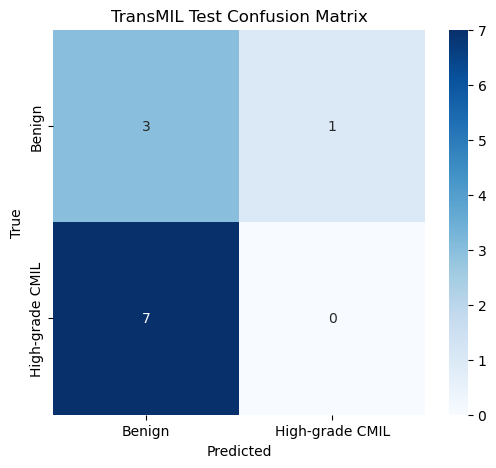

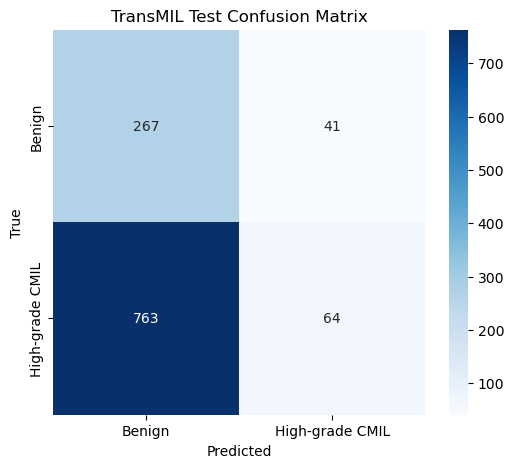

In [17]:
# Plot confusion matrix
cm = confusion_matrix(all_trues, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign','High-grade CMIL'],
            yticklabels=['Benign','High-grade CMIL'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("TransMIL Test Confusion Matrix")
plt.show()

# Plot confusion matrix
cm = confusion_matrix(all_patch_trues, all_patch_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign','High-grade CMIL'],
            yticklabels=['Benign','High-grade CMIL'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("TransMIL Test Confusion Matrix")
plt.show()





=== Patch-Level Classification Report (PatchClassifier) ===
                 precision    recall  f1-score   support

         Benign       0.36      0.29      0.32       308
High-grade CMIL       0.75      0.81      0.78       827

       accuracy                           0.67      1135
      macro avg       0.56      0.55      0.55      1135
   weighted avg       0.65      0.67      0.65      1135



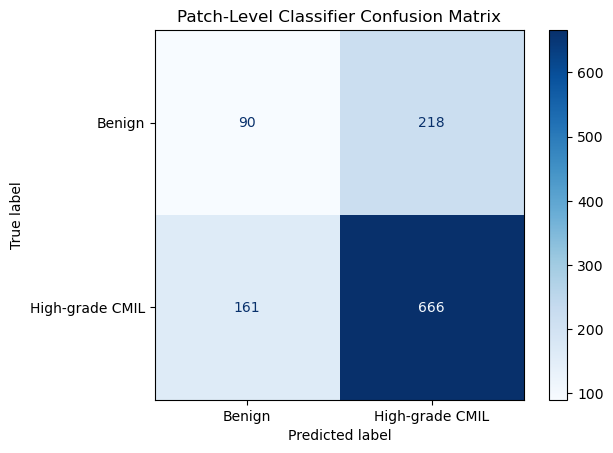

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_patch_model(model, test_loader, device):
    model.eval()
    all_preds, all_trues = [], []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_trues.extend(labels.numpy())

    print("\n=== Patch-Level Classification Report (PatchClassifier) ===")
    print(classification_report(all_trues, all_preds, target_names=['Benign', 'High-grade CMIL'], labels=[0,1]))

    # Confusion Matrix
    cm = confusion_matrix(all_trues, all_preds, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'High-grade CMIL'])
    disp.plot(cmap="Blues", values_format='d')
    plt.title("Patch-Level Classifier Confusion Matrix")
    plt.show()

evaluate_patch_model(patch_model, patch_test_loader, device)